# Nondeterministic Actions: Solving Tic-Tac-Toe with AND-OR-Tree Search

## Introduction 
 
Multiplayer games can be implemented as:
1. __Nondeterministic actions:__ The opponent is seen as part of an environment with nondeterministic actions. Non-determinism is the result of the unknown opponent's moves. 
2. Optimal Decisions: Minimax search (search complete game tree) and alpha-beta pruning.
3. Heuristic Alpha-Beta Tree Search: Cut off tree search and use heuristic to estimate state value. 
4. Monte Carlo Tree search: Simulate playouts to estimate state value. 

Here we will implement search for Tic-Tac-Toe (see [rules](https://en.wikipedia.org/wiki/Tic-tac-toe)).

We will implement
* __AND-OR-Tree search.__

Each action consists of the move by the player (OR levels in the tree) and all possible (i.e., nondeterministic) responses by the opponents (AND levels). The action therefore results in a set of possible states.

We will search for a __conditional plan__ using AND-OR-Tree search. 

The code for the basic functions used for search are implemented in [tictactoe.py](tictactoe.py).

In [10]:
from tictactoe import empty_board, actions, result, terminal, utility, other, show_board
from tictactoe import random_player, play 

## Solving Tic-Tac-Toe using AND-OR-Tree Search

The opponent can be modeled as part of the environment. The opponent's action as a response to the agent's 
action makes the environment appear non-deterministic (see AIMA page 125 or the slides). The ADS-OR-Tree algorithm uses the following functions:

* `is_goal(state)`: determine if the current board/state has a winner.
* `is_cycle(path)`: determine if we are in a loop (the tic-tac-toe problem has no loops so I do not implement it).
* `results(state, action)`: returns all states following state + action.


### Cycles

The path is typically used for loop checking. We ignore it here since tic-tac-toe does not have cycles.

### Goals

Reaching the goal means that the agent has successfully finished the task. 

For games, `terminal(s)` checks if `s` is a terminal state, but a terminal state can also indicate that 
the player lost (which indicates a failure). This can determined by the 
`utility(s)` function. Tic-tac-toe also has draws and we need to decide if a draw is considered successfully reaching
the goal or a failure.

### Non-deterministic Results

Since the opponent and her moves are part of the environment, `results()` returns for a state $\times$ action combination a set of new states that reflects all possible responses by the opponent.

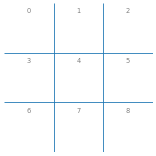


Set of possible state for placing an x at position 4 of an empty board and the opponent's move:


[['o', ' ', ' ', ' ', 'x', ' ', ' ', ' ', ' '],
 [' ', 'o', ' ', ' ', 'x', ' ', ' ', ' ', ' '],
 [' ', ' ', 'o', ' ', 'x', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', 'o', 'x', ' ', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', 'x', 'o', ' ', ' ', ' '],
 [' ', ' ', ' ', ' ', 'x', ' ', 'o', ' ', ' '],
 [' ', ' ', ' ', ' ', 'x', ' ', ' ', 'o', ' '],
 [' ', ' ', ' ', ' ', 'x', ' ', ' ', ' ', 'o']]

In [11]:
def results(state, action, player = 'x'):
    """produce the set of states after the provided action for player. 
       It is the set of boards with the action and all possible reactions by the opponent."""
    
    opponent = other(player)
    state = state.copy()
    
    # player's move
    state[action] = player
    
    # opponent reacts
    r = list()
    o_actions = actions(state)
    
    # board is full
    if len(o_actions) < 1 : return [state]
    
    for o_a in o_actions:
        s = state.copy()
        s[o_a] = opponent
        r.append(s)    
    
    return r

show_board(empty_board())

print()
print("Set of possible state for placing an x at position 4 of an empty board and the opponent's move:")
results(empty_board(), 4)

### Recursive AND-OR Search (DFS)

In [12]:
# define global variables for debugging
DEBUG = 1
COUNT = 0 # used to report the number of searched nodes

def and_or_search(state, player = 'x', draw_is_win = True):
    """start the search. Consider draw_is_win a goal state?"""
    global DEBUG, COUNT
    COUNT = 0
    
    plan = or_search(state, player, draw_is_win)
    
    if DEBUG >= 1: 
        print(f"Number of nodes searched: {COUNT}")  
    
    return plan
 

def or_search(state, player, draw_is_win):
    """Or step of the search: the player makes a move. 
    We try all possible action and return a conditional 
    plan for the first action that only has goal states as leaf nodes. 
    If none can be found, then failure (None) is returned.
    
    Note: path is not used in this implementation since tic-tac-toe does not 
    need cycle checking.
    """
    global DEBUG, COUNT
    COUNT += 1
    
    # goal check
    u = utility(state, player)
    if u == -1 or (not draw_is_win and u == 0): return None # failure
     
    # cycles check: tic-tac-toe has no cycles

    # check all possible actions
    for action in actions(state):
        plan = and_search(results(state, action, player), player, draw_is_win)
        if plan is not None: 
            return [action, plan]
    
    # failure
    return None


def and_search(states, player, draw_is_win):
    """And step of the search: Represents all opponent's possible moves. 
    Follow all possible states (call the or step). 
    Return a conditional plan only if all paths lead to a goal state."""
    global DEBUG, COUNT
    COUNT += 1
    
    # return plans only if no state fails
    plans = []
    for s in states:
        # goal check
        u = utility(s, player)
        if u == 1: return "win"  # success
        if draw_is_win and u == 0: return "draw"

        plan = or_search(s, player, draw_is_win)
        
        if plan is None: 
            return None    # found a state that fails so we abandon this subtree!
        plans.append(['if', s, 'then', plan])
        
    return plans

And-or search looks for a subtree (i.e., an action) that guarantees a win and returns a conditional plan for this subtree. If no such subtree exists, no plan is returned. The algorithm only searches a fraction of the game tree since it abandons the current subtree when it finds the first leaf node that is not a win (see `and_search` function).

# Some Tests

## # x is about to win

Board:


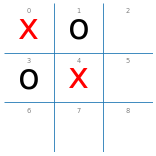


Win or draw:
Number of nodes searched: 22


[2,
 [['if', ['x', 'o', 'x', 'o', 'x', 'o', ' ', ' ', ' '], 'then', [6, 'win']],
  ['if',
   ['x', 'o', 'x', 'o', 'x', ' ', 'o', ' ', ' '],
   'then',
   [5,
    [['if', ['x', 'o', 'x', 'o', 'x', 'x', 'o', 'o', ' '], 'then', [8, 'win']],
     ['if',
      ['x', 'o', 'x', 'o', 'x', 'x', 'o', ' ', 'o'],
      'then',
      [7, 'draw']]]]],
  ['if',
   ['x', 'o', 'x', 'o', 'x', ' ', ' ', 'o', ' '],
   'then',
   [5,
    [['if', ['x', 'o', 'x', 'o', 'x', 'x', 'o', 'o', ' '], 'then', [8, 'win']],
     ['if',
      ['x', 'o', 'x', 'o', 'x', 'x', ' ', 'o', 'o'],
      'then',
      [6, 'win']]]]],
  ['if',
   ['x', 'o', 'x', 'o', 'x', ' ', ' ', ' ', 'o'],
   'then',
   [5,
    [['if',
      ['x', 'o', 'x', 'o', 'x', 'x', 'o', ' ', 'o'],
      'then',
      [7, 'draw']],
     ['if',
      ['x', 'o', 'x', 'o', 'x', 'x', ' ', 'o', 'o'],
      'then',
      [6, 'win']]]]]]]

CPU times: user 3.14 ms, sys: 966 μs, total: 4.11 ms
Wall time: 4.03 ms


In [13]:
board = empty_board() 
board[0] = 'x'
board[1] = 'o'
board[3] = 'o'
board[4] = 'x'

print("Board:")
show_board(board)

print()
print("Win or draw:")
%time display(and_or_search(board, player = 'x', draw_is_win = True))

Why does it play 2 and not 8!!!

In [14]:
print("Win only:")
%time display(and_or_search(board, player = 'x', draw_is_win = False))

Win only:
Number of nodes searched: 30


[2,
 [['if', ['x', 'o', 'x', 'o', 'x', 'o', ' ', ' ', ' '], 'then', [6, 'win']],
  ['if', ['x', 'o', 'x', 'o', 'x', ' ', 'o', ' ', ' '], 'then', [8, 'win']],
  ['if',
   ['x', 'o', 'x', 'o', 'x', ' ', ' ', 'o', ' '],
   'then',
   [5,
    [['if', ['x', 'o', 'x', 'o', 'x', 'x', 'o', 'o', ' '], 'then', [8, 'win']],
     ['if',
      ['x', 'o', 'x', 'o', 'x', 'x', ' ', 'o', 'o'],
      'then',
      [6, 'win']]]]],
  ['if', ['x', 'o', 'x', 'o', 'x', ' ', ' ', ' ', 'o'], 'then', [6, 'win']]]]

CPU times: user 5.48 ms, sys: 0 ns, total: 5.48 ms
Wall time: 4.98 ms


## x can draw_is_win if it chooses 7

Board:


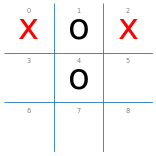


Win or draw:
Number of nodes searched: 64


[7,
 [['if',
   ['x', 'o', 'x', 'o', 'o', ' ', ' ', 'x', ' '],
   'then',
   [5,
    [['if', ['x', 'o', 'x', 'o', 'o', 'x', 'o', 'x', ' '], 'then', [8, 'win']],
     ['if',
      ['x', 'o', 'x', 'o', 'o', 'x', ' ', 'x', 'o'],
      'then',
      [6, 'draw']]]]],
  ['if',
   ['x', 'o', 'x', ' ', 'o', 'o', ' ', 'x', ' '],
   'then',
   [3,
    [['if',
      ['x', 'o', 'x', 'x', 'o', 'o', 'o', 'x', ' '],
      'then',
      [8, 'draw']],
     ['if',
      ['x', 'o', 'x', 'x', 'o', 'o', ' ', 'x', 'o'],
      'then',
      [6, 'win']]]]],
  ['if',
   ['x', 'o', 'x', ' ', 'o', ' ', 'o', 'x', ' '],
   'then',
   [3,
    [['if',
      ['x', 'o', 'x', 'x', 'o', 'o', 'o', 'x', ' '],
      'then',
      [8, 'draw']],
     ['if',
      ['x', 'o', 'x', 'x', 'o', ' ', 'o', 'x', 'o'],
      'then',
      [5, 'draw']]]]],
  ['if',
   ['x', 'o', 'x', ' ', 'o', ' ', ' ', 'x', 'o'],
   'then',
   [3,
    [['if', ['x', 'o', 'x', 'x', 'o', 'o', ' ', 'x', 'o'], 'then', [6, 'win']],
     ['if',
      ['x', '

CPU times: user 6.09 ms, sys: 0 ns, total: 6.09 ms
Wall time: 5.97 ms


In [15]:

board = empty_board() 
board[0] = 'x'
board[1] = 'o'
board[2] = 'x'
#board[3] = 'o'
board[4] = 'o'

print("Board:")
show_board(board)

print()
print("Win or draw:")
%time display(and_or_search(board, player = 'x', draw_is_win = True))

In [16]:
print("Win only:")
%time display(and_or_search(board, player = 'x', draw_is_win = False))

Win only:
Number of nodes searched: 69


None

CPU times: user 5.93 ms, sys: 0 ns, total: 5.93 ms
Wall time: 5.45 ms


## o is about to win

Board:


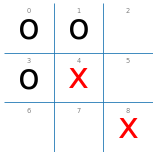


Win or draw:
Number of nodes searched: 11


None

CPU times: user 1.27 ms, sys: 0 ns, total: 1.27 ms
Wall time: 1.08 ms


In [17]:
board = empty_board() 
board[0] = 'o'
board[1] = 'o'
board[3] = 'o'
board[4] = 'x'
board[8] = 'x'

print("Board:")
show_board(board)

print()
print("Win or draw:")
%time display(and_or_search(board, player = 'x', draw_is_win = True))

Check for player o

In [18]:
print("Win only:")
%time display(and_or_search(board, player = 'o', draw_is_win = False))

Win only:
Number of nodes searched: 2


[2, 'win']

CPU times: user 2.78 ms, sys: 32 μs, total: 2.81 ms
Wall time: 2.16 ms


## Empty board: Only a draw_is_win can be guaranteed

Board:


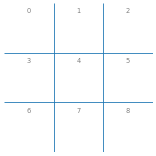


Win or draw:
Number of nodes searched: 966


[0,
 [['if',
   ['x', 'o', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
   'then',
   [2,
    [['if',
      ['x', 'o', 'x', 'o', ' ', ' ', ' ', ' ', ' '],
      'then',
      [4,
       [['if',
         ['x', 'o', 'x', 'o', 'x', 'o', ' ', ' ', ' '],
         'then',
         [6, 'win']],
        ['if',
         ['x', 'o', 'x', 'o', 'x', ' ', 'o', ' ', ' '],
         'then',
         [5,
          [['if',
            ['x', 'o', 'x', 'o', 'x', 'x', 'o', 'o', ' '],
            'then',
            [8, 'win']],
           ['if',
            ['x', 'o', 'x', 'o', 'x', 'x', 'o', ' ', 'o'],
            'then',
            [7, 'draw']]]]],
        ['if',
         ['x', 'o', 'x', 'o', 'x', ' ', ' ', 'o', ' '],
         'then',
         [5,
          [['if',
            ['x', 'o', 'x', 'o', 'x', 'x', 'o', 'o', ' '],
            'then',
            [8, 'win']],
           ['if',
            ['x', 'o', 'x', 'o', 'x', 'x', ' ', 'o', 'o'],
            'then',
            [6, 'win']]]]],
        ['if',
        

CPU times: user 37.2 ms, sys: 54 μs, total: 37.3 ms
Wall time: 37.2 ms


In [19]:
board = empty_board() 

print("Board:")
show_board(board)

print()
print("Win or draw:")
%time display(and_or_search(board, player = 'x', draw_is_win = True))

In [20]:
print("Win only:")
%time display(and_or_search(board, player = 'x', draw_is_win = False))

Win only:
Number of nodes searched: 16213


None

CPU times: user 320 ms, sys: 1.99 ms, total: 322 ms
Wall time: 323 ms


## Experiments

### And-Or Tree Search vs. Random

Put AND-OR search into a wrapper agent function. Note that if AND-OR search cannot guarantee a win then
it does not return a plan, nut `None`. In this case, we do not know what the best (i.e., the least "bad") 
move is, so I make the agent play randomly. Other methods that we will learn about later can determine the utility of a move, even if it does not guarantee a win.

In [21]:
DEBUG = 0

def and_or_player(board, player = 'x'):
    plan = and_or_search(board, player)

    # if there is no plan then we do a random action
    if plan is None: 
        return np.random.choice(actions(board))
    else:
        return plan[0]


print("and-or-search vs. random:")
%time display(play(and_or_player, random_player))

print()
print("random vs. and-or-search")
%time display(play(random_player, and_or_player))

and-or-search vs. random:


{'x': 92, 'o': 0, 'd': 8}

CPU times: user 2.49 s, sys: 3.09 ms, total: 2.49 s
Wall time: 2.5 s

random vs. and-or-search


{'x': 0, 'o': 69, 'd': 31}

CPU times: user 4.85 s, sys: 63 μs, total: 4.85 s
Wall time: 4.85 s


**Note how slow this is!**

My lazy implementation is a _simple reflex agent_ that recreates a conditional plan every time it is asked for an action. ut since And-Or search already produces a complete conditional plan for the empty board, a better implementation would use a _model-based reflex agent_ that store this precomputed plan and just follow it without more planing.

### And-Or Tree Search vs. And-Or Tree Search

In [22]:
# No randomness -> run only once

%time display(play(and_or_player, and_or_player, N = 1))

{'x': 0, 'o': 0, 'd': 1}

CPU times: user 94.4 ms, sys: 1.99 ms, total: 96.4 ms
Wall time: 94.8 ms
